In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [20]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
#import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.decoding as dec

In [3]:
import importlib

In [4]:
%matplotlib notebook

In [5]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'

# Select data to plot

In [6]:
experiment = 'gratings'
trial_epoch = 'stimulus'
responsive_test='ROC'
# --------------------------------------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
metad = sdata[sdata.experiment.isin(experiment_list)].copy()

traces001|dff_responsive-ROC-thr0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


# Decoding settings

In [50]:
C_value=1.0
test_split=0.2
cv_nfolds=3
chance_level = 1/8. if experiment=='gratings' else 0.5

In [51]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [52]:
analysis_type='by_fov'
test_type= 'ori_single' #'ori_single' #'size_single'
class_name = 'ori'
variation_name = None
match_rfs = False
overlap_thr= None #[0, 0.25, 0.5]
split_arousal=True

basedir = dec.create_results_dir(analysis_type=analysis_type, test_type=test_type, 
                                class_name=class_name, variation_name=variation_name,
                                 split_arousal=split_arousal)

Base output dir: /n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single_arousal


#### Set output dirs

In [53]:
aggr_id = dec.create_aggregate_id(C_value=C_value, 
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            match_rfs=match_rfs, overlap_thr=overlap_thr)
dst_dir = os.path.join(basedir, aggr_id)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)
print(aggr_id)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'decoding')
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single_arousal/dff-ROC__stimulus__noRF__C1.00
dff-ROC__stimulus__noRF__C1.00


# Load data

In [101]:
experiment = 'gratings' if class_name=='ori' else 'blobs'
print(analysis_type, test_type, class_name, variation_name)
iterdf, missing_ = dec.load_iterdf(metad, class_name,
                          experiment=experiment,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rfs, overlap_thr=overlap_thr,
                          split_arousal=True)
if match_rfs and (responsive_test=='ROC'):
    iterdf = iterdf[iterdf.n_cells<=96]

by_fov ori_single ori None
(V1) Found 4 paths
(Lm) Found 4 paths
(Li) Found 5 paths
    checking for break-corrs
(V1) Found 0 paths
(Lm) Found 0 paths
(Li) Found 0 paths


In [102]:
if 'train_transform' in iterdf.columns:
    iterdf['sf'] = [round(float(i.split('_')[0]), 1) for i in iterdf['train_transform'].values]
    iterdf['size'] = [int(float(i.split('_')[1])) for i in iterdf['train_transform'].values]
    iterdf['speed'] = [int(float(i.split('_')[2])) for i in iterdf['train_transform'].values]
    iterdf['size_type'] = ['fullfield' if i==200 else 'apertured' \
                          for i in iterdf['size'].values]

In [103]:
importlib.reload(gutils)

<module 'analyze2p.gratings.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/gratings/utils.py'>

#### Add low/high rel values

In [104]:
iterdf, error_configs = gutils.check_high_low_param_values(iterdf)
    

In [143]:
iterdf.columns

Index(['fit_time', 'score_time', 'test_score', 'train_score',
       'heldout_test_score', 'C', 'randi', 'condition', 'train_transform',
       'test_transform', 'n_trials', 'novel', 'iteration', 'n_cells',
       'arousal', 'visual_area', 'datakey', 'intact', 'noise_corrs', 'sf',
       'size', 'speed', 'size_type', 'size_rel', 'sf_rel', 'speed_rel'],
      dtype='object')

#### Print out scoretable

In [106]:
del iterdf['overlap_thr']


In [107]:
iterdf.shape, iterdf.dropna().shape

((198000, 26), (188000, 26))

In [108]:
grouper = ['visual_area', 'condition', 'iteration', 'arousal']
if test_type=='ori_single':
    grouper.extend(['train_transform', 'sf_rel', 'size_rel', 'speed_rel'])
mean_df0 = dec.average_within_iterations_by_ncells(iterdf.dropna(), 
                            analysis_type=analysis_type, test_type=test_type,
                            grouper=grouper) 
if test_type is not None:
    score_table = mean_df0[ (mean_df0.condition=='data')]\
            .groupby([ 'visual_area', 'arousal', 'size_rel'])\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=['visual_area', 'arousal'], columns=['size_rel'])
else:
    score_table = mean_df0[(mean_df0.condition=='data')]\
            .groupby([ 'visual_area', 'arousal'])\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index='visual_area', columns='arousal')
print("EXP: %s (class=%s). Test: %s, %s" % (experiment, class_name, test_type, aggr_id))
score_table

EXP: gratings (class=ori). Test: ori_single, dff-ROC__stimulus__noRF__C1.00


heldout_test_score          
size_rel                          high       low
visual_area arousal                             
Li          high              0.139982  0.134671
            low               0.144168  0.123824
Lm          high              0.231482  0.274513
            low               0.221768  0.202758
V1          high              0.216079  0.307492
            low               0.176179  0.269810

In [109]:
iterdf['novel'].unique()

array([False])

#### Check status of pupil data

In [110]:
import analyze2p.arousal.dlc_utils as dlcutils

In [111]:
# Pupil -------------------------------------------
pupil_feature='pupil_fraction'
pupil_epoch='stimulus'
pupil_snapshot=391800
redo_pupil=False
pupil_framerate=20.
# -------------------------------------------------
alignment_type='trial'
iti_pre=1.0
iti_post=1.0

print("[%s] ITI pre/post: %.2f/%.2f sec\nEpoch: %s, Alignment: %s" \
      % (experiment, iti_pre, iti_post, pupil_epoch, alignment_type))
# Aggregate dataframes
aggr_pupilmetrics, aggr_params, missing_ = dlcutils.aggregate_dataframes(experiment, 
                            trial_epoch=pupil_epoch, alignment_type=alignment_type,
                            in_rate=pupil_framerate, out_rate=pupil_framerate,
                            iti_pre=iti_pre, iti_post=iti_post, return_missing=True,
                            create_new=False, realign=False, recombine=False,
                            exclude_old=True)
something_missing = [i for v in [v for k, v in missing_.items()] for i in v]

print("Missing %i datasets:" % len(something_missing))
missing_

[gratings] ITI pre/post: 1.00/1.00 sec
Epoch: stimulus, Alignment: trial
~~~~~~~~~~~~ Aggregating pupil dataframes. ~~~~~~~~~~~
Re-aggregating
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
    (gratings) Excluding 20190314_JC070_fov1
    (gratings) Excluding 20190315_JC070_fov2
    (gratings) Excluding 20190319_JC067_fov1
    (gratings) Excluding 20190321_JC070_fov2
    (gratings) Excluding 20190522_JC089_fov1
    (gratings) Excluding 20190612_JC099_fov1
    (gratings) Excluding 20190306_JC061_fov2
    (gratings) Excluding 20190517_JC083_fov1
    (gratings) Excluding 20190627_JC091_fov1
Missing 0 datasets:


{'metrics': array([], dtype=float64), 'traces': array([], dtype=float64)}

In [112]:
check_ = pd.DataFrame([(dk, len(par['missing_trials'])) \
                       for dk, par in aggr_params.items()], columns=['datakey', 'n_missing_trials'])
check_

,datakey,n_missing_trials
0,20190527_JC092_fov3,0
1,20190602_JC091_fov1,1043
2,20190606_JC091_fov1,951
3,20190607_JC091_fov1,549
4,20190609_JC099_fov1,60
5,20190614_JC091_fov1,49
6,20190617_JC099_fov1,2
7,20191018_JC113_fov1,0
8,20191111_JC120_fov1,7
9,20190512_JC083_fov1,179


In [124]:
(20*64)/2.

too_many_missing = check_[check_['n_missing_trials']>700]['datakey'].unique()
too_many_missing

array(['20190602_JC091_fov1', '20190606_JC091_fov1'], dtype=object)

In [125]:
(20*64)/2


640.0

# Get finaldf

In [126]:
print(analysis_type, test_type)
# grouper = ['visual_area', 'condition', 'datakey', 'intact']
grouper = ['visual_area', 'condition', 'datakey', 'arousal'] #, 'novel']
if test_type=='ori_single':
    grouper.extend(['train_transform', 'sf_rel', 'size_rel', 'speed_rel'])
    
iterdf_x = iterdf[~iterdf.datakey.isin(too_many_missing)].copy()
mean_df = dec.average_across_iterations_by_fov(iterdf_x,
                        analysis_type=analysis_type, test_type=test_type,
                        grouper=grouper)
if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())
print("arousal:", mean_df['arousal'].unique())
print("intact/break_cc:", mean_df['intact'].unique())
mean_df.columns

by_fov ori_single
novel: [False]
conditions: ['data' 'shuffled']
arousal: ['high' 'low']
intact/break_cc: [ True]


Index(['visual_area', 'condition', 'datakey', 'arousal', 'train_transform',
       'sf_rel', 'size_rel', 'speed_rel', 'novel', 'fit_time', 'score_time',
       'test_score', 'train_score', 'heldout_test_score', 'C', 'randi',
       'n_trials', 'iteration', 'n_cells', 'intact', 'sf', 'size', 'speed'],
      dtype='object')

In [127]:
iterdf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Li    5
V1    4
Lm    4
Name: visual_area, dtype: int64

In [128]:
#### Drop repeats, get finaldf
match_ncells=False
# ---------------------------------
all_counts = mean_df[['visual_area', 'datakey', 'n_cells']].drop_duplicates()
max_ncells = all_counts.groupby('visual_area')['n_cells'].max().min() if match_ncells\
                else all_counts.groupby('visual_area')['n_cells'].max().max() 
min_ncells = all_counts.groupby('visual_area')['n_cells'].min().max() if match_ncells\
                else 10
print(min_ncells, max_ncells)
# Get sample sizes
n_iters = iterdf['iteration'].max() +1
# sample_sizes = [s for s in sorted(iterdf['n_cells'].unique()) if s <=max_ncells]
# xlabels = [1, 32, 96, max_ncells]
# filter too few/too many cells
fov_filter_str = 'matchNcells' if match_ncells else 'allcells'
passdf = mean_df[(mean_df['n_cells']>=min_ncells) 
                    & (mean_df['n_cells']<=max_ncells)].copy()
counts = passdf[['visual_area', 'datakey', 'n_cells']].copy().drop_duplicates()
# Drop repeat FOVs based on N fits
u_dkeys = aggr.drop_repeats(counts, criterion='max', colname='n_cells')
finaldf = pd.concat([g for (va, dk), g in passdf.groupby(['visual_area', 'datakey'])\
                if (va, dk) in u_dkeys])

10 186.0


In [129]:
finaldf.columns

Index(['visual_area', 'condition', 'datakey', 'arousal', 'train_transform',
       'sf_rel', 'size_rel', 'speed_rel', 'novel', 'fit_time', 'score_time',
       'test_score', 'train_score', 'heldout_test_score', 'C', 'randi',
       'n_trials', 'iteration', 'n_cells', 'intact', 'sf', 'size', 'speed'],
      dtype='object')

# Calculate and plot scores

In [136]:
maindf = finaldf.copy() #[finaldf.train_transform!=10].copy()
plot_groupby=['visual_area', 'datakey', 'arousal', 'condition']
if test_type=='ori_single':
    plot_groupby.extend([ 'train_transform', 'size_rel', 'sf_rel', 'speed_rel'])
paired_df = maindf\
            .groupby(plot_groupby).mean()\
            .reset_index()
paired_df['sf'] = paired_df['sf'].round(1)
# plotd = paired_df[(paired_df['size']<200) 
#               & (paired_df['sf']==0.1) & (paired_df['speed']==20)].copy()


In [140]:
plotd = paired_df.groupby(['visual_area', 'datakey', 'condition', 'arousal'])\
                 .mean().reset_index()


In [141]:
dkey_counts = plotd[['visual_area', 'datakey']].drop_duplicates()\
                .groupby('visual_area').count()
dkey_counts

,datakey
visual_area,
Li,5
Lm,4
V1,3


<IPython.core.display.Javascript object>


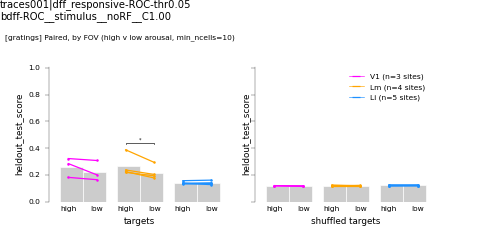

   t_stat  p_val visual_area
1   3.311  0.045          Lm
   t_stat  p_val visual_area condition
0    1.70   0.23          V1      data
1    3.31   0.04          Lm      data
2   -0.01   0.99          Li      data
0    1.93   0.19          V1  shuffled
1    0.03   0.98          Lm  shuffled
2   -0.36   0.74          Li  shuffled
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single_arousal/dff-ROC__stimulus__noRF__C1.00 paired_accuracy_arousal_heldout_test_score


In [173]:
%matplotlib notebook
c1='high'
c2='low'
compare_var='arousal'
metric='heldout_test_score'
if analysis_type=='by_fov':
    s_=[]
    fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
    for ai, (cond, datad) in enumerate(plotd.groupby('condition')):
        ax=axn[ai]
        ax, pstats = pplot.pairwise_compare_single_metric(datad, 
                         curr_metric=metric, ax=ax, bar_ci=None,
                         c1=c1, c2=c2, compare_var=compare_var,
                         return_stats=True, marker='.', size=2, edgecolor=['w']*3,
                         facecolor=[0.8]*3, annotate=True, sig_lw=0.5,
                         sig_fontsize=4, sig_height=0.01, sig_offset=None)
        pstats['condition'] = cond
        s_.append(pstats)
statsdf = pd.concat(s_, axis=0)
print(statsdf.round(2))

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.75)
for ai, ax in enumerate(axn):
    ax.set_xlabel('')
    #xtick_labels = ['int', 'shuff.']*3
    ax.set_xlabel('targets') if ai==0 else ax.set_xlabel('shuffled targets')
    #ax.set_xticklabels(xtick_labels)
    ax.set_ylim([0, 1.01])
labels = ['%s (n=%i sites)' % (va, dkey_counts.loc[va]) for va in visual_areas]
leg_h = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas],
                                   labels=labels, markers='_')
axn[1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper right', frameon=False)

fig.text(0.01, 0.85, \
    '[%s] Paired, by FOV (high v low arousal, min_ncells=%i)'\
         % (experiment, min_ncells))
pplot.label_figure(fig, '%s\nb%s' % (data_id, aggr_id))

figname = 'paired_accuracy_arousal_%s' % metric
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

#### split by config

In [144]:
finaldf['train_transform_num'] = finaldf['train_transform'].values
finaldf['train_transform_rel'] = ['_'.join([sf, sz, sp]) for sf, sz, sp \
                                 in finaldf[['sf_rel', 'size_rel', 'speed_rel']].values]
finaldf.head()

,visual_area,condition,datakey,arousal,train_transform,sf_rel,size_rel,speed_rel,novel,fit_time,...,randi,n_trials,iteration,n_cells,intact,sf,size,speed,train_transform_num,train_transform_rel
0,Li,data,20190609_JC099_fov1,high,0.1_200.0_10.0,low,high,low,False,0.000927,...,5050.588,48.0,249.5,38.0,True,0.1,200.0,10.0,0.1_200.0_10.0,low_high_low
1,Li,data,20190609_JC099_fov1,high,0.1_200.0_20.0,low,high,high,False,0.000912,...,4964.962,48.0,249.5,38.0,True,0.1,200.0,20.0,0.1_200.0_20.0,low_high_high
2,Li,data,20190609_JC099_fov1,high,0.1_30.0_10.0,low,low,low,False,0.000962,...,4988.904,48.0,249.5,38.0,True,0.1,30.0,10.0,0.1_30.0_10.0,low_low_low
3,Li,data,20190609_JC099_fov1,high,0.1_30.0_20.0,low,low,high,False,0.000916,...,4948.082,48.0,249.5,38.0,True,0.1,30.0,20.0,0.1_30.0_20.0,low_low_high
4,Li,data,20190609_JC099_fov1,high,0.5_200.0_10.0,high,high,low,False,0.000926,...,4991.308,48.0,249.5,38.0,True,0.5,200.0,10.0,0.5_200.0_10.0,high_high_low


In [145]:
curr_grouper = ['visual_area', 'datakey', 'arousal', 'condition']
curr_grouper.extend(['train_transform_rel'])
df = finaldf[~(finaldf.novel)]\
            .groupby(curr_grouper).mean()\
            .reset_index()
# ===============================
compare_var='arousal'
metric='heldout_test_score'
c1 = 'high'
c2 = 'low'
s_=[]
for train_transform, df_ in df.groupby('train_transform_rel'):
    split_ = dec.calculate_relative_scores(df_.copy(), metric=metric,
                                            compare_var=compare_var,
                                            c1=c1, c2=c2)
    split_['train_transform_rel'] = train_transform
    s_.append(split_)
split_scores = pd.concat(s_, axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


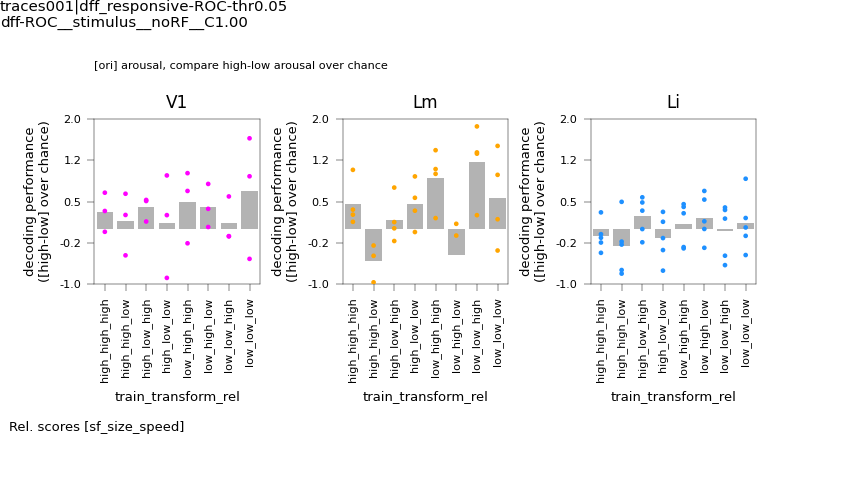

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single_arousal/dff-ROC__stimulus__noRF__C1.00 split_by_config_acc-over-chance_high-v-low-arousal


In [168]:
fig, axn=pl.subplots(1, 3, figsize=(7,4), dpi=150, sharex=True, sharey=False)
for va, vg in split_scores.groupby('visual_area'):
    ax = axn[visual_areas.index(va)]
    sns.barplot(x='train_transform_rel', y='%s_v_%s' % (c1, c2), data=vg, ax=ax,
            color=[0.7]*3, ci=None)
    sns.stripplot(x='train_transform_rel', y='%s_v_%s' % (c1, c2), data=vg, ax=ax,
            hue='visual_area', palette=area_colors, jitter=False,
            size=5, marker='.')
    ax.set_title(va)
    ax.legend_.remove()
ymin=-1 #0.5
ymax=2
for ax in axn.flat:
    ax.set_box_aspect(1)
    ax.set_ylim([ymin, ymax])
    ax.set_yticks(np.linspace(ymin, ymax, 5))
    ax.set_yticklabels([round(i, 1) for i in np.linspace(ymin, ymax, 5)])
    ax.set_ylabel('decoding performance\n([%s-%s] over chance)' % (c1, c2))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.3, top=0.95, wspace=0.5)

fig.text(0.1, 0.87, '[%s] %s, compare %s-%s arousal over chance' \
         % (class_name, compare_var, c1, c2))
fig.text(0.01, 0.2, 'Rel. scores [sf_size_speed]', fontsize=7)


pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
figname = 'split_by_config_acc-over-chance_high-v-low-arousal'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

#### scores over chance

In [153]:
metric='heldout_test_score'
compare_var = 'arousal'
c1 = 'high'
c2 = 'low'
scores_over_chance = dec.calculate_relative_scores(paired_df, compare_var=compare_var,
                                                  c1=c1, c2=c2, metric=metric)


In [157]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

<IPython.core.display.Javascript object>


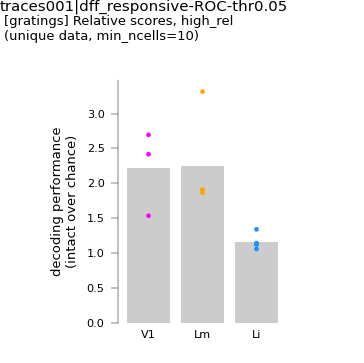

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single_arousal/dff-ROC__stimulus__noRF__C1.00 rel_scores_high_rel-arousal_gratings


<IPython.core.display.Javascript object>


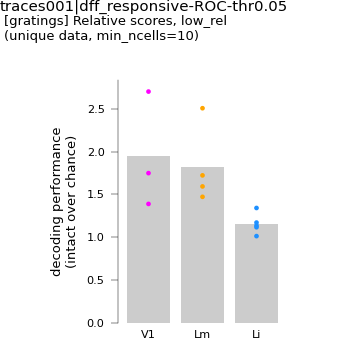

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single_arousal/dff-ROC__stimulus__noRF__C1.00 rel_scores_low_rel-arousal_gratings


In [158]:
df_ = scores_over_chance.copy() #
%matplotlib notebook
posthoc = 'fdr_by'
#metric = 'high_rel'
# ---------------------
for metric in ['high_rel', 'low_rel']:
    fig = pplot.plot_standard_panel(df_, metric, posthoc=posthoc)
    fig.axes[0].set_ylabel('decoding performance\n(intact over chance)')
    fig.text(0.01, 0.9, '[%s] Relative scores, %s\n(unique data, min_ncells=%i)' \
             % (experiment, metric, min_ncells), fontsize=7)
    pplot.label_figure(fig, data_id)
    figname = 'rel_scores_%s-arousal_%s' % (metric, experiment)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)
   

<IPython.core.display.Javascript object>


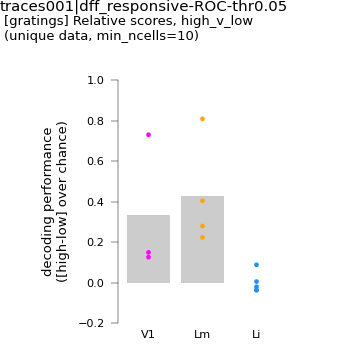

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single_arousal/dff-ROC__stimulus__noRF__C1.00 rel_scores_high_v_low-arousal_gratings


In [172]:
%matplotlib notebook
posthoc = 'fdr_by'
metric = '%s_v_%s' % (c1, c2)
# ---------------------
fig = pplot.plot_standard_panel(df_, metric, posthoc=posthoc)
fig.axes[0].set_ylabel('decoding performance\n([%s-%s] over chance)' % (c1, c2))
fig.axes[0].set_ylim([-0.2, 1])
fig.text(0.01, 0.9, '[%s] Relative scores, %s\n(unique data, min_ncells=%i)' \
         % (experiment, metric, min_ncells), fontsize=7)
pplot.label_figure(fig, data_id)

figname = 'rel_scores_%s-arousal_%s' % (metric, experiment)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)